In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore")

In [3]:
# ==========================================
# 1. Load and Clean Data
# ==========================================
print("Loading data...")
df = pd.read_csv('2003-2024.csv')
df.rename(columns={'Total Consumption (MLD)': 'Consumption'}, inplace=True)
df['Year'] = df['Year'].astype(int)

# Identify states with missing 2023-2024 data
states_incomplete = ['Sabah', 'Sarawak']
states_all = df['State'].unique()

Loading data...


In [4]:
# ==========================================
# 2. Train Global Hybrid Model (on available data)
# ==========================================
# We train the ML model on ALL available data (Johor, Selangor, etc. up to 2024)
# so it learns the "general rules" of water consumption to help Sabah/Sarawak.

df_sorted = df.sort_values(by=['State', 'Year'])
df_sorted['Lag1'] = df_sorted.groupby('State')['Consumption'].shift(1)
df_sorted['Lag2'] = df_sorted.groupby('State')['Consumption'].shift(2)

# Training Set: All rows where we have Lag1, Lag2, and Consumption
df_train = df_sorted.dropna()

# Features for Trend (Year) and Residuals (Lags)
X_trend_train = pd.get_dummies(df_train[['Year', 'State']], columns=['State'], drop_first=False)
y_train = df_train['Consumption']

# Train Linear Regression (Trend)
lr_model = LinearRegression()
lr_model.fit(X_trend_train, y_train)
df_train['Trend_Pred'] = lr_model.predict(X_trend_train)
df_train['Residuals'] = df_train['Consumption'] - df_train['Trend_Pred']

# Train Random Forest (Residuals)
X_rf_train = pd.get_dummies(df_train[['Lag1', 'Lag2', 'State']], columns=['State'], drop_first=False)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_rf_train, df_train['Residuals'])

# Prepare Features: We use Lags + Year + State (One-Hot Encoded)
# This differs slightly from your Hybrid residuals training by including 'Year' directly
X_ml_train = pd.get_dummies(df_train[['Lag1', 'Lag2', 'Year', 'State']], columns=['State'], drop_first=False)
y_ml_train = df_train['Consumption']

# Train Standalone Random Forest
# (This predicts total consumption directly, unlike the hybrid RF which predicted residuals)
rf_standalone = RandomForestRegressor(n_estimators=200, random_state=42)
rf_standalone.fit(X_ml_train, y_ml_train)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
xgb_model.fit(X_ml_train, y_ml_train)

print("XGBoost and Standalone Random Forest models successfully trained.")
print("Global Hybrid Model Trained.")

XGBoost and Standalone Random Forest models successfully trained.
Global Hybrid Model Trained.


In [ ]:
# ==========================================
# 3. FILL THE GAP: Predict 2023-2024 for Sabah/Sarawak
# ==========================================
print("\nFilling missing 2023-2024 data for Sabah & Sarawak...")

imputed_rows = []

for state in states_incomplete:
    # Get history (2015-2022)
    state_hist = df_sorted[df_sorted['State'] == state].copy()

    # A. ARIMA Model (Univariate)
    arima_model = ARIMA(state_hist['Consumption'], order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=2) # Forecast 2023, 2024

    # B. Hybrid Model (Recursive)
    # Start with known lags from 2022
    current_lag1 = state_hist.iloc[-1]['Consumption'] # 2022 value
    current_lag2 = state_hist.iloc[-2]['Consumption'] # 2021 value

    years_to_fill = [2023, 2024]

    for i, year in enumerate(years_to_fill):
        # 1. Prepare Input for Trend
        row_trend = pd.DataFrame({'Year': [year], 'State': [state]})
        row_trend_enc = pd.get_dummies(row_trend, columns=['State'], drop_first=False)
        row_trend_enc = row_trend_enc.reindex(columns=X_trend_train.columns, fill_value=0)
        trend_val = lr_model.predict(row_trend_enc)[0]

        # 2. Prepare Input for Residuals
        row_rf = pd.DataFrame({'Lag1': [current_lag1], 'Lag2': [current_lag2], 'State': [state]})
        row_rf_enc = pd.get_dummies(row_rf, columns=['State'], drop_first=False)
        row_rf_enc = row_rf_enc.reindex(columns=X_rf_train.columns, fill_value=0)
        resid_val = rf_model.predict(row_rf_enc)[0]

        # 3. Hybrid Prediction
        hybrid_pred = trend_val + resid_val

        # 4. Ensemble (Average)
        arima_pred = arima_forecast.iloc[i]
        final_val = (hybrid_pred + arima_pred) / 2

        # Save to list
        imputed_rows.append({
            'State': state,
            'Year': year,
            'Consumption': final_val,
            'Type': 'Imputed (Estimated)'
        })

        # Update lags for next step
        current_lag2 = current_lag1
        current_lag1 = final_val

# Add imputed rows to main dataframe
df_imputed = pd.DataFrame(imputed_rows)
df_full = pd.concat([df, df_imputed[['State', 'Year', 'Consumption']]], ignore_index=True)
df_full = df_full.sort_values(by=['State', 'Year']).reset_index(drop=True)

print("Gap filling complete. Dataset is now continuous 2015-2024 for all states.")


Filling missing 2023-2024 data for Sabah & Sarawak...
Gap filling complete. Dataset is now continuous 2015-2024 for all states.


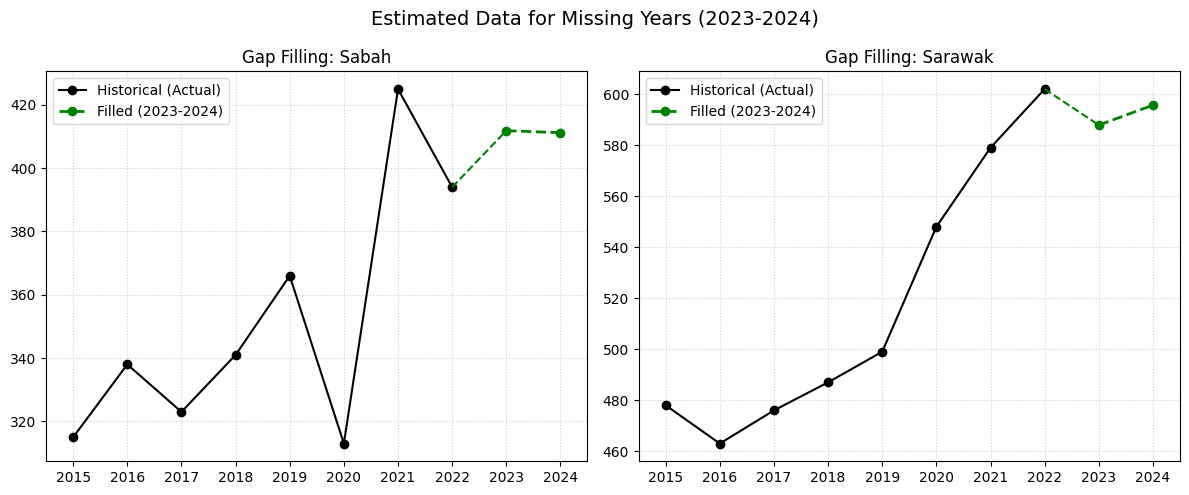

2003-2024 with filled gap


In [6]:
# ==========================================
# 4. VISUALIZE 2023-2024 (Sabah & Sarawak Only)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, state in enumerate(states_incomplete):
    ax = axes[i]

    # --- MODIFIED SECTION ---
    # Filter historical data to show only 2015 onwards for the plot.
    # The original 'df' still contains 2003 data for your ML models.
    hist_data = df[(df['State'] == state) & (df['Year'] >= 2015)]
    # ------------------------

    # Plot History
    ax.plot(hist_data['Year'], hist_data['Consumption'], 'o-', label='Historical (Actual)', color='black')

    # Plot Imputed
    imp_data = df_imputed[df_imputed['State'] == state]

    # Connect line (Connects last historical point to first imputed point)
    if not hist_data.empty and not imp_data.empty:
        last_hist = hist_data.iloc[-1]
        first_imp = imp_data.iloc[0]
        ax.plot([last_hist['Year'], first_imp['Year']],
                [last_hist['Consumption'], first_imp['Consumption']], 'g--')

    ax.plot(imp_data['Year'], imp_data['Consumption'], 'go--', label='Filled (2023-2024)', linewidth=2)

    ax.set_title(f"Gap Filling: {state}")

    # Ensure x-axis shows exactly 2015-2024
    ax.set_xticks(range(2015, 2025))
    ax.set_xlim(2014.5, 2024.5)  # Optional: Adds a little padding to the sides

    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()

plt.suptitle("Estimated Data for Missing Years (2023-2024)", fontsize=14)
plt.tight_layout()
plt.savefig('gap_filling_sabah_sarawak.png')
plt.show()

df_complete_filled = pd.concat([df, df_imputed]).sort_values(by=['State', 'Year'])
df_complete_filled.to_csv('2003-2024_with_filled_gaps.csv', index=False)
print("2003-2024 with filled gap")


Generating Future Forecasts (2025-2029) - Comparing Models...
Detailed predictions saved to 'final_prediction_breakdown.csv'
Plot saved to 'model_comparison_forecast.png'


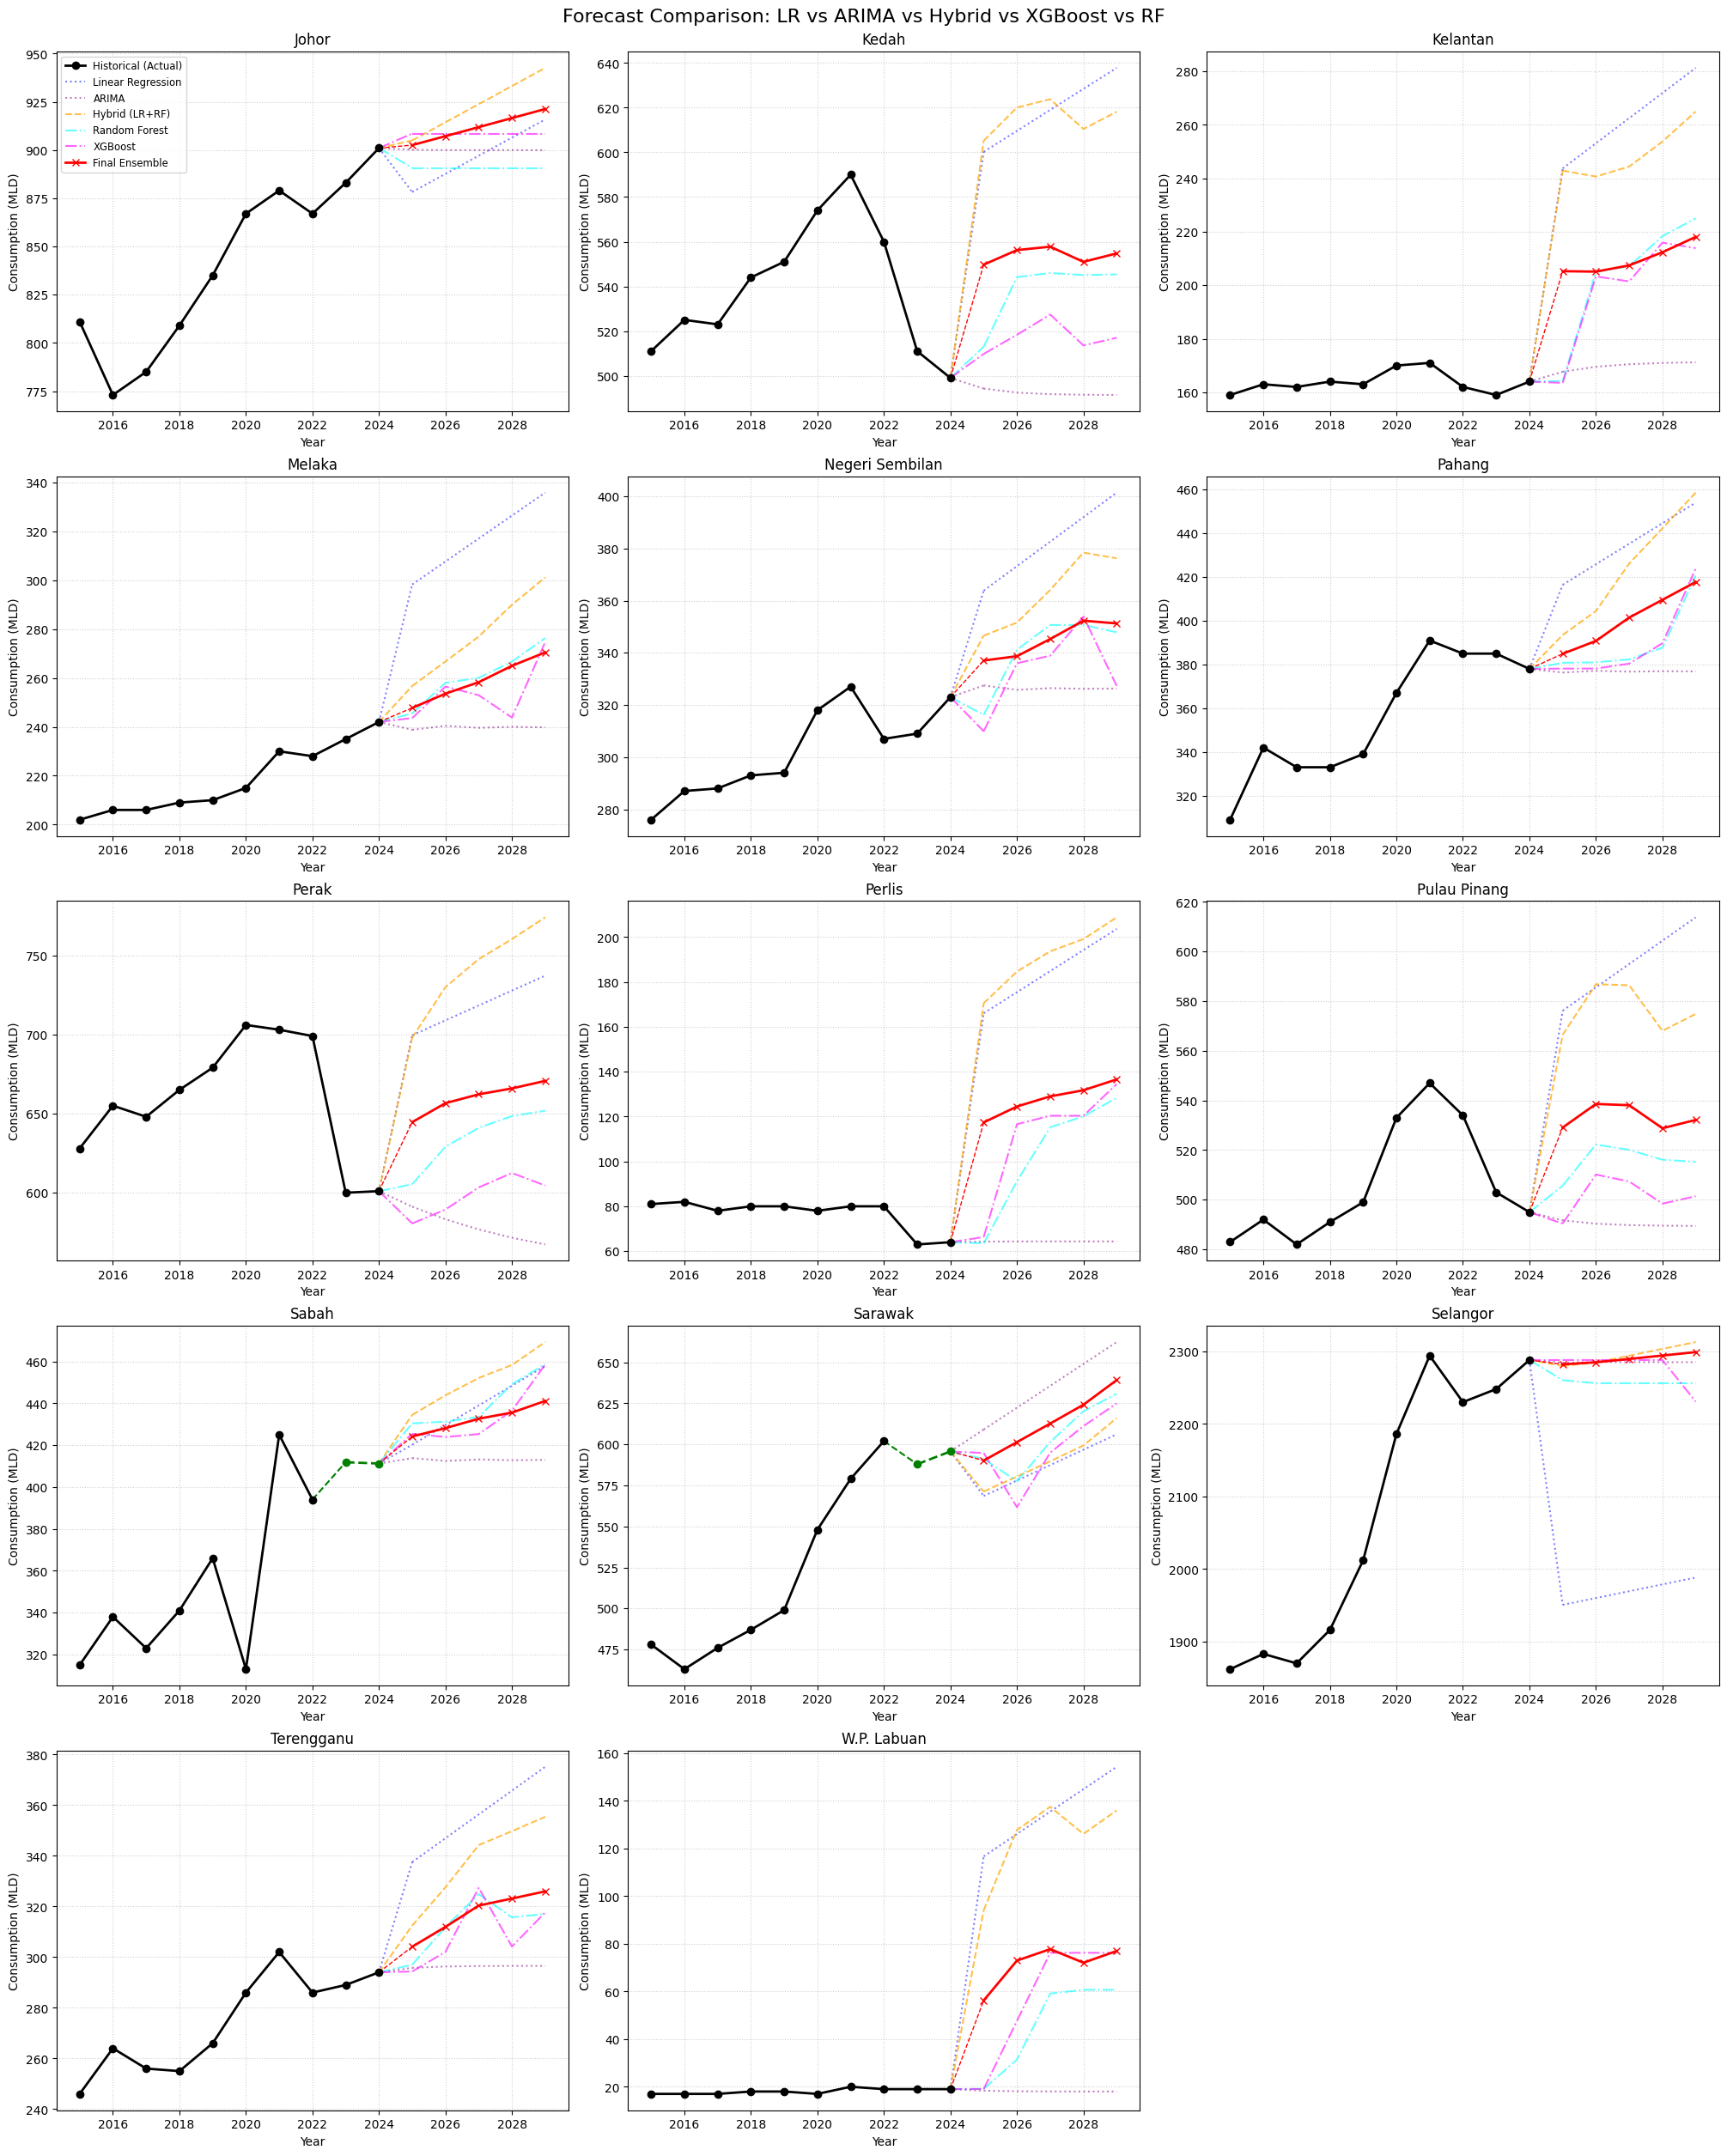

In [7]:
# ==============================================================================
# 5. FORECAST 2025-2029 (Breakdown by Model) - UPDATED WITH XGBOOST & RF
# ==============================================================================

print("\nGenerating Future Forecasts (2025-2029) - Comparing Models...")

# Re-calculate Lags on the now FULL dataset
df_full['Lag1'] = df_full.groupby('State')['Consumption'].shift(1)
df_full['Lag2'] = df_full.groupby('State')['Consumption'].shift(2)

# --- BEGIN RE-TRAINING FOR CONSISTENCY (FIX FOR FEATURE MISMATCH ERROR) ---
df_sorted_for_training = df.sort_values(by=['State', 'Year'])
df_sorted_for_training['Lag1'] = df_sorted_for_training.groupby('State')['Consumption'].shift(1)
df_sorted_for_training['Lag2'] = df_sorted_for_training.groupby('State')['Consumption'].shift(2)
df_train_consistent = df_sorted_for_training.dropna()

# Re-derive X_trend_train and train lr_model
X_trend_train_consistent = pd.get_dummies(df_train_consistent[['Year', 'State']], columns=['State'], drop_first=False)
ylr_train_consistent = df_train_consistent['Consumption']
lr_model = LinearRegression() # Re-initialize and re-train lr_model
lr_model.fit(X_trend_train_consistent, ylr_train_consistent)

df_train_consistent['Trend_Pred'] = lr_model.predict(X_trend_train_consistent)
df_train_consistent['Residuals'] = df_train_consistent['Consumption'] - df_train_consistent['Trend_Pred']

# Re-derive X_rf_train and train rf_model (Hybrid Residuals)
X_rf_train_consistent = pd.get_dummies(df_train_consistent[['Lag1', 'Lag2', 'State']], columns=['State'], drop_first=False)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42) # Re-initialize and re-train rf_model
rf_model.fit(X_rf_train_consistent, df_train_consistent['Residuals'])

# --- NEW ADDITION: Train Standalone RF and XGBoost ---
# These models use Year + Lags + State to predict Consumption directly
X_ml_train_consistent = pd.get_dummies(df_train_consistent[['Lag1', 'Lag2', 'Year', 'State']], columns=['State'], drop_first=False)
y_ml_train_consistent = df_train_consistent['Consumption']

# 1. Standalone Random Forest
rf_standalone_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_standalone_model.fit(X_ml_train_consistent, y_ml_train_consistent)

# 2. XGBoost
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
xgb_model.fit(X_ml_train_consistent, y_ml_train_consistent)

# Save feature names to ensure alignment during prediction
X_ml_columns = X_ml_train_consistent.columns
# -----------------------------------------------------

# Update X_trend_train and X_rf_train to use the consistent versions for prediction loops
X_trend_train = X_trend_train_consistent
X_rf_train = X_rf_train_consistent
# --- END RE-TRAINING FOR CONSISTENCY ---

future_years = [2025, 2026, 2027, 2028, 2029]
forecast_results = []

for state in states_all:
    # Get series (includes imputed data)
    state_series = df_full[df_full['State'] == state].set_index('Year')['Consumption']

    # 1. Train ARIMA on full history
    arima_model = ARIMA(state_series, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=5)

    # Prepare for Recursive Hybrid
    current_lag1 = state_series.iloc[-1] # 2024 value
    current_lag2 = state_series.iloc[-2] # 2023 value

    for i, year in enumerate(future_years):
        # 2. Linear Regression (Trend)
        row_trend = pd.DataFrame({'Year': [year], 'State': [state]})
        row_trend_enc = pd.get_dummies(row_trend, columns=['State'], drop_first=False)
        row_trend_enc = row_trend_enc.reindex(columns=X_trend_train.columns, fill_value=0)
        trend_val = lr_model.predict(row_trend_enc)[0]

        # 3. Random Forest (Residual)
        row_rf = pd.DataFrame({'Lag1': [current_lag1], 'Lag2': [current_lag2], 'State': [state]})
        row_rf_enc = pd.get_dummies(row_rf, columns=['State'], drop_first=False)
        row_rf_enc = row_rf_enc.reindex(columns=X_rf_train.columns, fill_value=0)
        resid_val = rf_model.predict(row_rf_enc)[0]

        # --- NEW ADDITION: Predict with Standalone RF and XGBoost ---
        row_ml = pd.DataFrame({'Lag1': [current_lag1], 'Lag2': [current_lag2], 'Year': [year], 'State': [state]})
        row_ml_enc = pd.get_dummies(row_ml, columns=['State'], drop_first=False)
        row_ml_enc = row_ml_enc.reindex(columns=X_ml_columns, fill_value=0)

        pred_rf_standalone = rf_standalone_model.predict(row_ml_enc)[0]
        pred_xgb = xgb_model.predict(row_ml_enc)[0]
        # ------------------------------------------------------------

        # --- Damping Factor for Small States ---
        if current_lag1 < 200:
            resid_val = resid_val * 0.5
        # ---------------------------------------

        # Hybrid (LR + RF)
        hybrid_pred = trend_val + resid_val

        # Get ARIMA Prediction for this year
        arima_pred = arima_forecast.iloc[i]

        # 4. Final Ensemble (Average)
        # We can now include the new models in the ensemble if desired,
        # but here we keep your original logic (Hybrid + ARIMA) or expand it.
        # Let's keep the original ensemble logic to not "change the coding" logic too much,
        # but you can easily change the divisor to 4 to include all.
        final_pred = (hybrid_pred + arima_pred) / 2

        # STORE ALL PREDICTIONS
        forecast_results.append({
            'State': state,
            'Year': year,
            'Pred_LR': trend_val,
            'Pred_ARIMA': arima_pred,
            'Pred_Hybrid': hybrid_pred,
            'Pred_RF': pred_rf_standalone, # NEW: Standalone RF
            'Pred_XGB': pred_xgb,          # NEW: XGBoost
            'Pred_Final': final_pred
        })

        # Update lags using the FINAL prediction (Best estimate of reality)
        current_lag2 = current_lag1
        current_lag1 = final_pred

# Save Predictions
final_df = pd.DataFrame(forecast_results).round(2)
final_df.to_csv('final_prediction_breakdown.csv', index=False)
print("Detailed predictions saved to 'final_prediction_breakdown.csv'")

# ==========================================
# VISUALIZATION (Updated with Connection Lines)
# ==========================================
n_states = len(states_all)
n_cols = 3
n_rows = (n_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

for i, state in enumerate(states_all):
    ax = axes[i]

    # --- 1. Historical (Showing 2015-2024) ---
    hist = df[(df['State'] == state) & (df['Year'] >= 2015)].sort_values('Year')
    ax.plot(hist['Year'], hist['Consumption'], 'o-', color='black', label='Historical (Actual)', linewidth=2, zorder=10)

    # Get the last historical point (to connect from)
    last_point_year = hist.iloc[-1]['Year']
    last_point_val = hist.iloc[-1]['Consumption']

    # --- 2. Imputed (Only for Sabah/Sarawak) ---
    if state in states_incomplete:
        imp = df_imputed[df_imputed['State'] == state].sort_values('Year')
        ax.plot(imp['Year'], imp['Consumption'], 'go--', label='Filled (2023-2024)', linewidth=2, zorder=9)

        # Connect Historical to Imputed
        ax.plot([last_point_year, imp.iloc[0]['Year']],
                [last_point_val, imp.iloc[0]['Consumption']], 'g--')

        # Update last point to the end of imputed data
        last_point_year = imp.iloc[-1]['Year']
        last_point_val = imp.iloc[-1]['Consumption']

    # --- 3. Forecasts (All Models) ---
    fcst = final_df[final_df['State'] == state].sort_values('Year')
    first_year = fcst.iloc[0]['Year']

    # --- PLOT & CONNECT EACH MODEL ---

    # Model A: Linear Regression (Blue Dotted)
    ax.plot(fcst['Year'], fcst['Pred_LR'], color='blue', linestyle=':', label='Linear Regression', alpha=0.5)
    # Connect
    ax.plot([last_point_year, first_year], [last_point_val, fcst.iloc[0]['Pred_LR']],
            color='blue', linestyle=':', alpha=0.5)

    # Model B: ARIMA (Purple Dotted)
    ax.plot(fcst['Year'], fcst['Pred_ARIMA'], color='purple', linestyle=':', label='ARIMA', alpha=0.5)
    # Connect
    ax.plot([last_point_year, first_year], [last_point_val, fcst.iloc[0]['Pred_ARIMA']],
            color='purple', linestyle=':', alpha=0.5)

    # Model C: Hybrid (Orange Dashed)
    ax.plot(fcst['Year'], fcst['Pred_Hybrid'], color='orange', linestyle='--', label='Hybrid (LR+RF)', alpha=0.7)
    # Connect
    ax.plot([last_point_year, first_year], [last_point_val, fcst.iloc[0]['Pred_Hybrid']],
            color='orange', linestyle='--', alpha=0.7)

    # Model E: Standalone RF (Cyan Dash-Dot)
    ax.plot(fcst['Year'], fcst['Pred_RF'], color='cyan', linestyle='-.', label='Random Forest', alpha=0.6)
    # Connect
    ax.plot([last_point_year, first_year], [last_point_val, fcst.iloc[0]['Pred_RF']],
            color='cyan', linestyle='-.', alpha=0.6)

    # Model F: XGBoost (Magenta Dash-Dot)
    ax.plot(fcst['Year'], fcst['Pred_XGB'], color='magenta', linestyle='-.', label='XGBoost', alpha=0.6)
    # Connect
    ax.plot([last_point_year, first_year], [last_point_val, fcst.iloc[0]['Pred_XGB']],
            color='magenta', linestyle='-.', alpha=0.6)

    # Model D: Final Ensemble (Red Solid)
    ax.plot(fcst['Year'], fcst['Pred_Final'], 'rx-', label='Final Ensemble', linewidth=2)
    # Connect
    ax.plot([last_point_year, first_year], [last_point_val, fcst.iloc[0]['Pred_Final']], 'r--', linewidth=1)

    ax.set_title(f"{state}")
    ax.set_xlabel('Year')
    ax.set_ylabel('Consumption (MLD)')
    ax.grid(True, linestyle=':', alpha=0.6)

    # Legend only on first plot
    if i == 0:
        ax.legend(loc='upper left', fontsize='small')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Forecast Comparison: LR vs ARIMA vs Hybrid vs XGBoost vs RF', fontsize=16)
plt.savefig('model_comparison_forecast.png')
print("Plot saved to 'model_comparison_forecast.png'")
plt.show()

Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training Hybrid (LR + RF)...
Training ARIMA...

--- Model Performance Comparison ---
               Model    RMSE      R2
2            XGBoost   30.34  0.9972
1      Random Forest   37.37  0.9958
4              ARIMA   54.00  0.9912
3     Hybrid (LR+RF)   67.47  0.9863
0  Linear Regression  126.97  0.9514


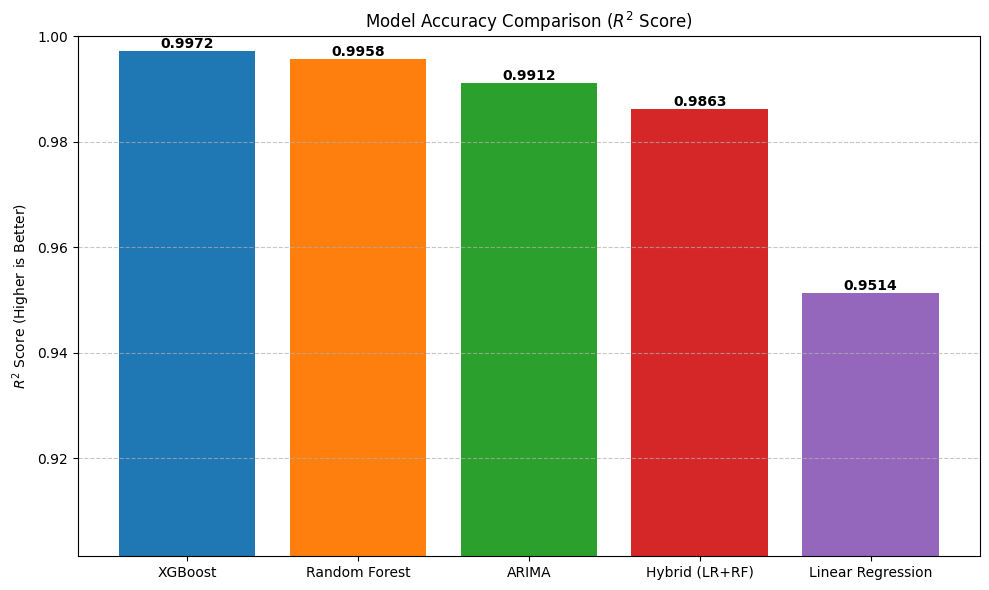

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Try importing XGBoost (Install if needed: !pip install xgboost)
try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None
    print("XGBoost not found. Skipping...")

# ==========================================
# 1. PREPARE DATA FOR COMPARISON
# ==========================================
# Load data
try:
    df = pd.read_csv('2003-2024.csv')
except FileNotFoundError:
    print("Error: '2003-2024.csv' not found. Please ensure the file is in the directory.")
    raise

df.rename(columns={'Total Consumption (MLD)': 'Consumption'}, inplace=True)
df['Year'] = df['Year'].astype(int)

# Use only states with COMPLETE data (Exclude Sabah/Sarawak)
states_incomplete = ['Sabah', 'Sarawak']
df_eval = df[~df['State'].isin(states_incomplete)].copy()

# Sort is CRITICAL here for ARIMA and Lag creation
df_eval = df_eval.sort_values(by=['State', 'Year'])

# Create Lags (Features for ML models)
df_eval['Lag1'] = df_eval.groupby('State')['Consumption'].shift(1)
df_eval['Lag2'] = df_eval.groupby('State')['Consumption'].shift(2)
df_eval = df_eval.dropna()

# Split: Train (2015-2022) vs Test (2023-2024)
train = df_eval[df_eval['Year'] < 2023].copy()
test = df_eval[df_eval['Year'] >= 2023].copy()

# Ensure Test set is sorted by State first (to match ARIMA loop order later)
test = test.sort_values(by=['State', 'Year'])

# Helper to Prepare Features (One-Hot Encoding for States)
def get_X_y(data, feature_cols, target='Consumption'):
    X = pd.get_dummies(data[feature_cols], columns=['State'], drop_first=False)
    return X, data[target]

def align_cols(X_train, X_test):
    # Add missing columns to test set with 0
    missing = set(X_train.columns) - set(X_test.columns)
    for c in missing: X_test[c] = 0
    # Reorder columns to match training set
    return X_train, X_test[X_train.columns]

# ==========================================
# 2. TRAIN MODELS
# ==========================================
predictions = {}

# --- Model A: Linear Regression (Baseline) ---
print("Training Linear Regression...")
cols_trend = ['Year', 'State']
X_lr_train, y_lr_train = get_X_y(train, cols_trend)
X_lr_test, y_lr_test = get_X_y(test, cols_trend)
X_lr_train, X_lr_test = align_cols(X_lr_train, X_lr_test)

lr = LinearRegression()
lr.fit(X_lr_train, y_lr_train)
predictions['Linear Regression'] = lr.predict(X_lr_test)

# --- Model B: Random Forest (Standalone) ---
print("Training Random Forest...")
cols_full = ['Year', 'State', 'Lag1', 'Lag2']
X_rf_train, y_rf_train = get_X_y(train, cols_full)
X_rf_test, y_rf_test = get_X_y(test, cols_full)
X_rf_train, X_rf_test = align_cols(X_rf_train, X_rf_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf_train, y_rf_train)
predictions['Random Forest'] = rf.predict(X_rf_test)

# --- Model C: XGBoost (Standalone) ---
if XGBRegressor:
    print("Training XGBoost...")
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb.fit(X_rf_train, y_rf_train)
    predictions['XGBoost'] = xgb.predict(X_rf_test)

# --- Model D: Hybrid (LR + RF) ---
print("Training Hybrid (LR + RF)...")
# 1. Train LR on Trend
lr_hybrid = LinearRegression()
lr_hybrid.fit(X_lr_train, y_lr_train)
train['Trend_Pred'] = lr_hybrid.predict(X_lr_train)
train['Residuals'] = train['Consumption'] - train['Trend_Pred']

# 2. Train RF on Residuals
cols_resid = ['Lag1', 'Lag2', 'State']
X_res_train, y_res_train = get_X_y(train, cols_resid, target='Residuals')
X_res_test, _ = get_X_y(test, cols_resid)
X_res_train, X_res_test = align_cols(X_res_train, X_res_test)

rf_hybrid = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hybrid.fit(X_res_train, y_res_train)

# 3. Combine Predictions
trend_pred = lr_hybrid.predict(X_lr_test)
resid_pred = rf_hybrid.predict(X_res_test)
predictions['Hybrid (LR+RF)'] = trend_pred + resid_pred

# --- Model E: ARIMA (Loop per State) ---
print("Training ARIMA...")
arima_preds_ordered = []

# ARIMA is univariate, so we loop through each state individually
states_in_test = test['State'].unique()

for state in states_in_test:
    # Get historical data for this state from the training set
    history = train[train['State'] == state]['Consumption'].values
    
    # Determine how many steps to forecast (rows in test set for this state)
    steps = len(test[test['State'] == state])
    
    if len(history) > 0:
        try:
            # (p,d,q) = (1,1,1) is a standard starting point for annual trends
            model = ARIMA(history, order=(1, 1, 1)) 
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=steps)
            arima_preds_ordered.extend(forecast)
        except Exception as e:
            # Fallback: If ARIMA fails to converge, use Naive Forecast (Last value)
            print(f"ARIMA failed for {state}, using naive fallback.")
            arima_preds_ordered.extend([history[-1]] * steps)
    else:
        arima_preds_ordered.extend([0] * steps)

predictions['ARIMA'] = np.array(arima_preds_ordered)

# ==========================================
# 3. EVALUATE & VISUALIZE
# ==========================================
print("\n--- Model Performance Comparison ---")
results = []

# Use the sorted test set for Ground Truth (matches the order of ARIMA loop)
y_true = test['Consumption'].values

for name, preds in predictions.items():
    # Double check lengths match
    if len(preds) != len(y_true):
        print(f"Warning: Length mismatch for {name}. Preds: {len(preds)}, True: {len(y_true)}")
        continue
        
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    results.append({'Model': name, 'RMSE': round(rmse, 2), 'R2': round(r2, 4)})

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print(results_df)

# Plotting
plt.figure(figsize=(10, 6))
# Define colors for up to 5 models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] 

bars = plt.bar(results_df['Model'], results_df['R2'], color=colors[:len(results_df)])

# Dynamic Y-axis scaling to highlight differences
min_r2 = results_df['R2'].min()
plt.ylim(max(0, min_r2 - 0.05), 1.0) 

plt.title('Model Accuracy Comparison ($R^2$ Score)')
plt.ylabel('$R^2$ Score (Higher is Better)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# ==========================================
# PREPARE DATA FOR TABLEAU (History + Filled + Forecast)
# ==========================================

# 1. Prepare Original History (2003-2024 for most, 2003-2022 for Sabah/Sarawak)
df_hist = df[['State', 'Year', 'Consumption']].copy()
df_hist['Type'] = 'Historical'
df_hist['Model'] = 'Actual'

# 2. Prepare Filled Gaps (Sabah & Sarawak 2023-2024)
# We treat this as "Historical" but mark it as "Filled" so you can color it differently (e.g., Green)
df_filled = df_imputed[['State', 'Year', 'Consumption']].copy()
df_filled['Type'] = 'Historical (Filled)'
df_filled['Model'] = 'Gap Fill'  # Distinct name allows you to toggle it on/off

# 3. Prepare Forecast (Melt it to make it "tall" for Tableau)
# Added 'Pred_RF' and 'Pred_XGB' to value_vars
df_forecast = final_df.melt(id_vars=['State', 'Year'],
                            value_vars=['Pred_LR', 'Pred_ARIMA', 'Pred_Hybrid',
                                        'Pred_RF', 'Pred_XGB', 'Pred_Final'],
                            var_name='Model', value_name='Consumption')
df_forecast['Type'] = 'Prediction'

# Rename models for cleaner legend in Tableau
model_map = {
    'Pred_LR': 'Linear Regression (High)',
    'Pred_ARIMA': 'ARIMA (Momentum)',
    'Pred_Hybrid': 'Hybrid (Volatile)',
    'Pred_RF': 'Random Forest (Standalone)',
    'Pred_XGB': 'XGBoost (Gradient Boosting)',
    'Pred_Final': 'Final Ensemble (Best)'
}
df_forecast['Model'] = df_forecast['Model'].map(model_map)

# 4. Combine ALL datasets
df_tableau = pd.concat([df_hist, df_filled, df_forecast], ignore_index=True)

# 5. Sort for cleanliness
df_tableau = df_tableau.sort_values(by=['State', 'Year'])

# 6. Save
df_tableau.to_csv('Tableau_Master_Dataset.csv', index=False)
print("Success! 'Tableau_Master_Dataset.csv' created with History, Gap Fills, and Predictions (including XGBoost & RF).")

Success! 'Tableau_Master_Dataset.csv' created with History, Gap Fills, and Predictions (including XGBoost & RF).


In [10]:
import pandas as pd

# Load the user's uploaded dataset
df = pd.read_csv('Tableau_Master_Dataset.csv')

# 1. Identify the Anchor Data (The last point of history)
# We assume 2024 is the connection point based on previous context
anchor_year = 2024
df_anchor_source = df[(df['Year'] == anchor_year) & (df['Model'] == 'Actual')].copy()

# 2. Identify the Prediction Models we need to connect to
# We look at unique models that are NOT 'Actual' and NOT 'Gap Fill'
pred_models = df[~df['Model'].isin(['Actual', 'Gap Fill'])]['Model'].unique()

# 3. Generate the Anchor Rows
anchor_rows = []

for model in pred_models:
    # Create a copy of the actual data
    temp_df = df_anchor_source.copy()
    # Assign it to the prediction model so Tableau draws a line from here
    temp_df['Model'] = model
    temp_df['Type'] = 'Prediction'
    anchor_rows.append(temp_df)

# 4. Combine everything
if anchor_rows:
    df_anchors = pd.concat(anchor_rows)
    df_connected = pd.concat([df, df_anchors], ignore_index=True)
else:
    df_connected = df.copy()

# 5. Sort for cleanliness
df_connected = df_connected.sort_values(by=['State', 'Model', 'Year'])

# 6. Save
df_connected.to_csv('Tableau_Connected_Data.csv', index=False)

print(f"Created 'Tableau_Connected_Data.csv' with {len(df_connected)} rows.")
print("Anchor rows added for models:", pred_models)

Created 'Tableau_Connected_Data.csv' with 800 rows.
Anchor rows added for models: <StringArray>
[   'Linear Regression (High)',            'ARIMA (Momentum)',
           'Hybrid (Volatile)',  'Random Forest (Standalone)',
 'XGBoost (Gradient Boosting)',       'Final Ensemble (Best)']
Length: 6, dtype: str
